## PyTorch modules and layers

### What are modules?
Module is an abstraction somewhere between neural network *layer* and complete *model*. In PyTorch, there all kinds of things one can do with modules and their combinations.

![Multiple layers are combined into modules, forming repeating patterns of larger models.](./img/blocks.svg)

From a programming standpoint, a module is represented by a class. Any subclass of it must:
  - define a forward propagation method that transforms its input into output
  - store any necessary parameters.

Start with necessary imports:

In [14]:
import torch
from torch import nn
from torch.nn import functional as F

### Module chaining
We can use a built-in `Sequential` function to chain layers together. The below code creates a hidden layer with 256 neurons and ReLU activation function, and an output layer with 10 neurons:

In [4]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand(2, 20)
net(X).shape

torch.Size([2, 10])

### Forward propagation
**Important**: to use the model, we pass it the input data (`net(X)` in the above example). This executes the model's forward, along with some background operations.

`net(X)` is actually just shorthand for `net.__call__(X)`. `LazyLinear` is a version of `Linear` that *infers* output dimensions.

In [7]:
X.shape

torch.Size([2, 20])

### Create a module from scratch
In the following snippet, we code up a module from scratch corresponding to an MLP with one hidden layer with 256 hidden units, and a 10- dimensional output layer. Note that the MLP class below inherits the class that represents a module. We will heavily rely on the parent class’s methods, supplying only our own constructor (the __init__ method in Python) and the forward propagation method.

In [10]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

Let’s first focus on the forward propagation method. Note that it takes X as input, calculates the hidden representation with the activation function applied, and outputs its logits. In this MLP implementation, both layers are instance variables. To see why this is reasonable, imagine instantiating two MLPs, net1 and net2, and training them on different data. Naturally, we would expect them to represent two different learned models.

In [13]:
net = MLP()
net(X).shape

torch.Size([2, 10])

**So**: a module can abstract layers, complete models, or anything in-between.

### Writing your own `Sequential`

We need to define two key methods:

1. A method for appending modules one by one to a list.
2. A forward propagation method for passing an input through the chain of modules, in the same order as they were appended.


In [17]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

Note `add_module` and `children` funcs.

Now we can use it:

In [20]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

### Executing Code in the Forward Propagation Method

The `Sequential` class makes model construction easy,
allowing us to assemble new architectures
without having to define our own class.
However, not all architectures are simple daisy chains.
When greater flexibility is required,
we will want to define our own blocks.
For example, we might want to execute
Python's control flow within the forward propagation method.
Moreover, we might want to perform
arbitrary mathematical operations,
not simply relying on predefined neural network layers.

You may have noticed that until now,
all of the operations in our networks
have acted upon our network's activations
and its parameters.
Sometimes, however, we might want to
incorporate terms
that are neither the result of previous layers
nor updatable parameters.
We call these *constant parameters*.
Say for example that we want a layer
that calculates the function
$f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$,
where $\mathbf{x}$ is the input, $\mathbf{w}$ is our parameter,
and $c$ is some specified constant
that is not updated during optimization.
So we implement a `FixedHiddenMLP` class as follows.

In [23]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In this model,
we implement a hidden layer whose weights
(`self.rand_weight`) are initialized randomly
at instantiation and are thereafter constant.
This weight is not a model parameter
and thus it is never updated by backpropagation.
The network then passes the output of this "fixed" layer
through a fully connected layer.

Note that before returning the output,
our model did something unusual.
We ran a while-loop, testing
on the condition its $\ell_1$ norm is larger than $1$,
and dividing our output vector by $2$
until it satisfied the condition.
Finally, we returned the sum of the entries in `X`.
To our knowledge, no standard neural network
performs this operation.
Note that this particular operation may not be useful
in any real-world task.
Our point is only to show you how to integrate
arbitrary code into the flow of your
neural network computations.

In [26]:
net = FixedHiddenMLP()
net(X)

tensor(-0.2741, grad_fn=<SumBackward0>)

We can mix and match various ways of assembling modules together. In the following example, we nest modules in some creative ways.

In [29]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(-0.1930, grad_fn=<SumBackward0>)

### Parameters
Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
perhaps to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the nitty-gritty details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the weeds
of declaring and manipulating parameters.
In this section, we cover the following:

* Accessing parameters for debugging, diagnostics, and visualizations.
* Sharing parameters across different model components.

Let's use an MLP with one hidden layer:

In [32]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [34]:
X

tensor([[0.0907, 0.6154, 0.2359, 0.2122],
        [0.3219, 0.0126, 0.4267, 0.7949]])

How do we access each layer's parameters? Via indexing.

In [37]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[ 0.0574, -0.1500, -0.4512,  0.2515],
                      [ 0.0606, -0.2610, -0.3251, -0.2764],
                      [ 0.2115,  0.3000, -0.2557,  0.2019],
                      [-0.1145,  0.4039, -0.2552,  0.1682],
                      [-0.3217,  0.2666, -0.1501,  0.0733],
                      [ 0.0963, -0.3297, -0.1802,  0.2578],
                      [-0.2303, -0.2844, -0.2632,  0.1883],
                      [-0.2485, -0.4975, -0.1760,  0.2560]])),
             ('bias',
              tensor([-0.4413, -0.0813, -0.1595, -0.3215, -0.0571,  0.0746,  0.4767,  0.3417]))])

In [39]:
net[1].state_dict()

OrderedDict()

Note that parameters (weights/bias) are instances of a `torch.nn.parameter.Parameter` class.

In [42]:
net[2].weight

Parameter containing:
tensor([[ 0.2322,  0.1832,  0.0443,  0.2566,  0.3355, -0.2283,  0.0520,  0.2468]],
       requires_grad=True)

We can use `data` field in order to extract actual data:

In [45]:
net[2].weight.data

tensor([[ 0.2322,  0.1832,  0.0443,  0.2566,  0.3355, -0.2283,  0.0520,  0.2468]])

In [47]:
net[2].weight.shape

torch.Size([1, 8])

In [49]:
net[0].weight.shape

torch.Size([8, 4])

We can also access gradients for each layer:

In [52]:
net[2].weight.grad == None

True

We can also access parameters all at once via `nn.Module.named_parameters()`:

In [55]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

We can also tie or connect/share parameters in different layers.

In the following we allocate a fully connected layer
and then use its parameters specifically
to set those of another layer.
Here we need to run the forward propagation
`net(X)` before accessing the parameters.

In [58]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that the parameters
of the second and third layer are tied.
They are not just equal, they are
represented by the same exact tensor.
Thus, if we change one of the parameters,
the other one changes, too.

You might wonder,
when parameters are tied
what happens to the gradients?
Since the model parameters contain gradients,
the gradients of the second hidden layer
and the third hidden layer are added together
during backpropagation.



### Initialization

By default, PyTorch initializes weight and bias matrices uniformly by drawing from a range that is computed according to the input and output dimension. PyTorch’s nn.init module provides a variety of preset initialization methods.

Let's start with a sample neural network built with `nn.Sequential`.

In [62]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

### Built-in initializers

This code will initialize weights as Guassian random variables, and biases will be 0. The `apply` method applies the given function recursively to each submodule:

In [65]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0104, -0.0132, -0.0075, -0.0189]), tensor(0.))

Or we can use constants:

In [68]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can use indexing to initialize parameters for each layer separately:

In [71]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.0527, -0.3655,  0.5251, -0.3858])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Sometimes, the initialization methods we need
are not provided by the deep learning framework.
In the example below, we define an initializer
for any weight parameter $w$ using the following strange distribution (here $U$ stands for uniform distribution):

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \textrm{ with probability } \frac{1}{4} \\
            0    & \textrm{ with probability } \frac{1}{2} \\
        U(-10, -5) & \textrm{ with probability } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


In [74]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 9.4931,  0.0000, -0.0000, -6.5292],
        [-7.0455, -0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)

And, of course, we can always set the parameters directly:

In [77]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000,  1.0000, -5.5292])

Or in model class constructor:

In [80]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)



### Lazy initialization

PyTorch can defer parameter initialization, waiting until the first time we pass data through the model, to infer the sizes of each layer on the fly.

Later on, when working with convolutional neural networks, this technique will become even more convenient since the input dimensionality (e.g., the resolution of an image) will affect the dimensionality of each subsequent layer.

Let's create some perceptron again:

In [83]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

Check first layer params:

In [86]:
net[0].weight

<UninitializedParameter>

We can pass some data:

In [89]:
X = torch.rand(2, 20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

### Custom layers

Let's first try a layer without parameters:

In [93]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Let's see if it works:

In [96]:
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

We can use it in some models now:

In [99]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

Check how it works:

In [102]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(7.4506e-09, grad_fn=<MeanBackward0>)

The very small number instead of 0 is due to floating point number arithmetic.

Let's now create a custom layer with parameters: `in_units` and `out_units` for inputs and outputs counts.

In [106]:
class MyLinear(nn.Module):
    def __init__(self, in_units, out_units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, out_units))
        self.bias = nn.Parameter(torch.randn(out_units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

We can instantiate it and check parameters:

In [109]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.8819,  1.3070,  0.4321],
        [-1.2305, -1.7267,  0.0363],
        [-1.7148,  0.8182, -1.1052],
        [-1.4670, -0.0232, -0.2568],
        [-0.5308, -0.1465, -0.9315]], requires_grad=True)

Now invoke forward propagation using our custom layer:

In [112]:
linear(torch.rand(2, 5))

tensor([[0., 0., 0.],
        [0., 0., 0.]])

Now we can construct a model using the custom layer:

In [115]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[ 6.4418],
        [19.7892]])

### Loading and saving

Save a single tensor:

In [118]:
x = torch.arange(4)
torch.save(x, 'torch.data')
x

tensor([0, 1, 2, 3])

Now read it back:

In [121]:
x2 = torch.load('torch.data')
x2

tensor([0, 1, 2, 3])

Same can be done with lists of tensors:

In [124]:
y = torch.zeros(4)
torch.save([x, y],'torch2.data')
x2, y2 = torch.load('torch2.data')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Saving dictionaries of tensors also works:

In [127]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'torch_dict.data')
mydict2 = torch.load('torch_dict.data')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

How does this work for complete models? Let's check it, using the example model for multi-layer perceptron.

In [130]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.output = nn.LazyLinear(10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

We can save the parameters of that model with:

In [133]:
torch.save(net.state_dict(), 'mlp.params')

In order to load the model, we can do this:

In [136]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

Let's verify that original model and cloned model produce same results:

In [139]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## Walkthrough with TorchVision dataset

### Fetching data
Let's fetch some sample dataset:

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). We will use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Let's visualize some samples:

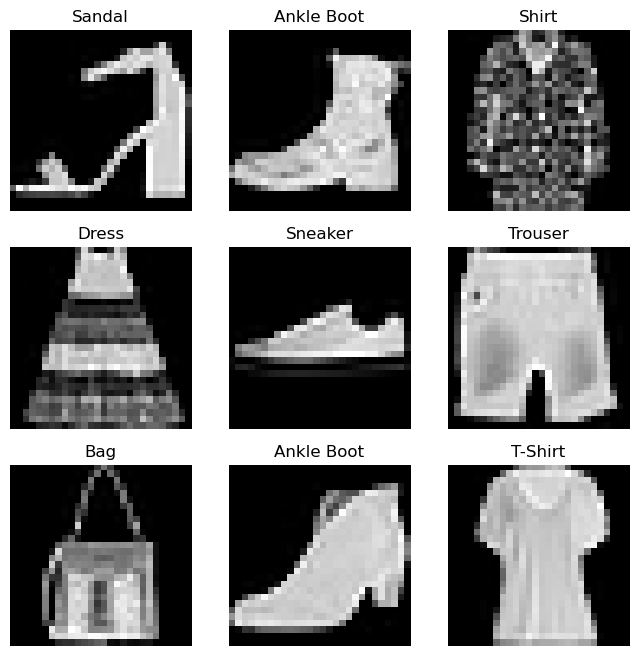

In [16]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Transforms

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we can use ToTensor and Lambda.

`target_transform` defines a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [19]:
%matplotlib inline

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Defining a network model

Now that we have the test data, define a neural network with 2 hidden layers and ReLU activation functions:

In [22]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Let's break down the steps:
  - initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).
  -  `nn.Linear` is a module that applies a linear transformation on the input using its stored weights and biases.
  -  `nn.ReLU` activations are applied after linear transformations to introduce nonlinearity.
  -  `nn.Sequential` orders the modules.

In order to train a model, we also need to specify a loss function and optimizer:

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Training loop

To sum up, in order to train a model, we need the following:
  - the dataloader that wraps over some dataset
  - model itself (derived from PyTorch's `nn.Module`)
  - loss function
  - optimizer

Needed steps are:
  - compure forward propagation
  - calculate loss
  - compute backward propagation
  - perform GD step

![A picture](./img/training_loop.png)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # This just sets the model in train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We'll also need a test function in order to verify how our model works. Note that we use `torch.no_grad()` as we don't need the gradients when testing:

In [32]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

![A picture](./img/testing_loop.png)

Let's run it:

In [36]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303587  [    0/60000]
loss: 2.288491  [ 6400/60000]
loss: 2.271456  [12800/60000]
loss: 2.267423  [19200/60000]
loss: 2.243748  [25600/60000]
loss: 2.230545  [32000/60000]
loss: 2.226344  [38400/60000]
loss: 2.196748  [44800/60000]
loss: 2.192217  [51200/60000]
loss: 2.168279  [57600/60000]
Test Error: 
 Accuracy: 48.6%, Avg loss: 2.156660 

Epoch 2
-------------------------------
loss: 2.163401  [    0/60000]
loss: 2.158713  [ 6400/60000]
loss: 2.096429  [12800/60000]
loss: 2.114750  [19200/60000]
loss: 2.071482  [25600/60000]
loss: 2.023115  [32000/60000]
loss: 2.036884  [38400/60000]
loss: 1.962607  [44800/60000]
loss: 1.958726  [51200/60000]
loss: 1.906228  [57600/60000]
Test Error: 
 Accuracy: 62.1%, Avg loss: 1.890752 

Epoch 3
-------------------------------
loss: 1.918332  [    0/60000]
loss: 1.899257  [ 6400/60000]
loss: 1.772417  [12800/60000]
loss: 1.812666  [19200/60000]
loss: 1.717556  [25600/60000]
loss: 1.674659  [32000/600

Save and load model:

In [38]:
torch.save(model.state_dict(), "model.pth")
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Let's use the model to make predictions:

In [42]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Switch model to evaluation mode
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
